In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Import the data set that represented by a CSV file, and defining the columns that describe the attributes of each record in the data set.

In [2]:
data_path = "conn_attack.csv"
dataset = pd.read_csv(data_path , names = ["Record_id","Duration","Src_bytes","Dst_bytes"] , header = None)

Before we perform the EDA step, we need to perform pre-processing on the data set to see if there are data that could mislead the model or that do not represent the sample space.

# **Preprocessing**
---
in this part, I will check if the dataset contains null values in each row, and also because our dataset represents network traffic and its may be weird if source bytes, destination bytes, and duration may have negative values.

In [8]:
# The isna() method returns a DataFrame object where all the values are replaced with a Boolean value True for NA (not-a -number) values, and otherwise False.
# The any() method returns one value for each column, True if ANY value in that column is True, otherwise False.
dataset.isna().any().any() 

False

In [9]:
(dataset < 0).any().any()

False

## **Exploratory Data Analysis** (EDA)

---
In statistics, exploratory data analysis (EDA) is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling and thereby contrasts traditional hypothesis testing. (Wikipedia)


In [10]:
print (f'Dataset shape : {dataset.shape}')

Dataset shape : (256670, 4)


Since we have two attributes in our data set that describe the number of bytes received and sent by the host, it is interesting to check whether for the same record - the number of bytes sent is greater than the number of bytes received?

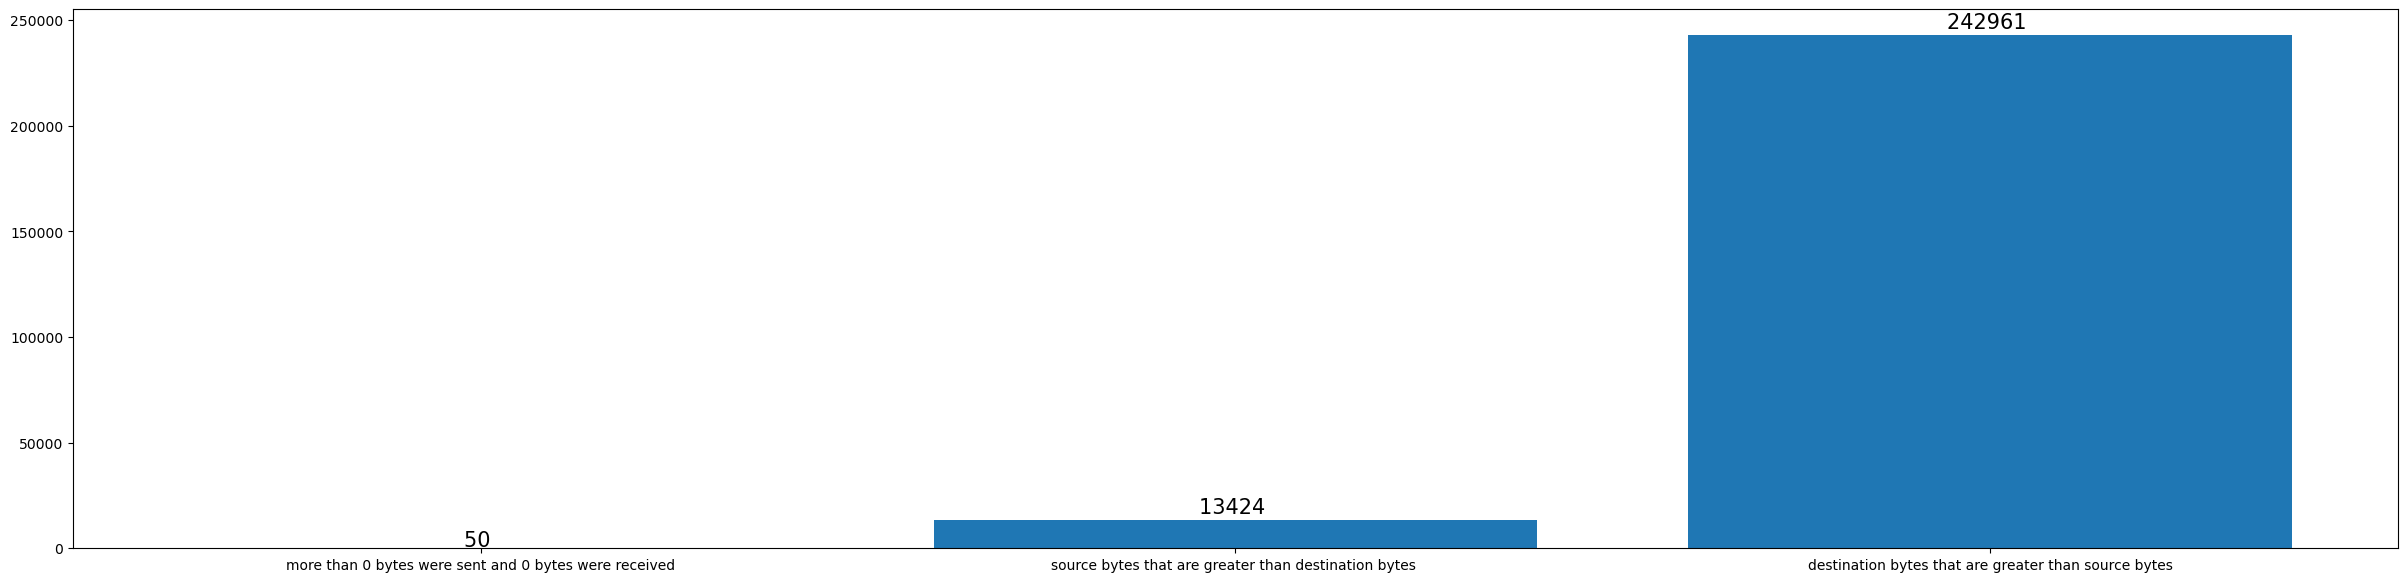

In [12]:
names = ['more than 0 bytes were sent and 0 bytes were received','source bytes that are greater than destination bytes ', 'destination bytes that are greater than source bytes']

values = [dataset[(dataset['Src_bytes'] > 0) & (dataset['Dst_bytes'] == 0)].shape[0],dataset[dataset['Dst_bytes'] < dataset['Src_bytes']].shape[0], dataset[dataset['Dst_bytes'] > dataset['Src_bytes']].shape[0]]

plt.figure(figsize=(30, 7))
plt.text(names[0], y = values[0] + 1000 , s=f"{values[0]} " , fontdict = dict(fontsize = 15),  horizontalalignment='center')
plt.text(names[1], y = values[1] + 3000, s=f"{values[1]} " , fontdict = dict(fontsize = 15) ,  horizontalalignment='center')
plt.text(names[2], y = values[2] + 3000, s=f"{values[2]} " , fontdict = dict(fontsize = 15) ,  horizontalalignment='center')
plt.bar(names, values)
plt.show()


As you can see there are 13,424 records (0.05% from the dataset) according to which the number of bytes sent by the host is greater than the number of destination bytes
In addition, there are 50 cases where 0 bytes were received when more than 0 bytes were sent.

does this raise the suspicion of anomalous information?

**Box Plot**

-----
Box plot is a type of chart often used in explanatory data analysis. Box plots visually show the distribution of numerical data and skewness through displaying the data quartiles (or percentiles) and averages.

Box plot divides the data into sections that each contain approximately 25% of the data in that set.


1. `Minimum Score`

  The lowest score, excluding outliers (shown at the end of the left whisker).

2. `Lower Quartile`

  Twenty-five percent of scores fall below the lower quartile value (also known as the first quartile).

3. `Median`

  The median marks the mid-point of the data and is shown by the line that divides the box into two parts (sometimes known as the second quartile). Half the scores are greater than or equal to this value and half are less.

4. `Upper Quartile`

  Seventy-five percent of the scores fall below the upper quartile value (also known as the third quartile). Thus, 25% of data are above this value.

5. `Maximum Score`

  The highest score, excluding outliers (shown at the end of the right whisker).


In [13]:
# this method calculate the limits of the box plot which represent the bounds for outlier points 
def calculate_limits(column):
  q1 = dataset[column].describe()['25%']
  q3 = dataset[column].describe()['75%']
  iqr = q3 - q1
  limit_lower = q1 - 1.5 * iqr
  limit_upper = q3 + 1.5 * iqr
  return limit_lower , limit_upper

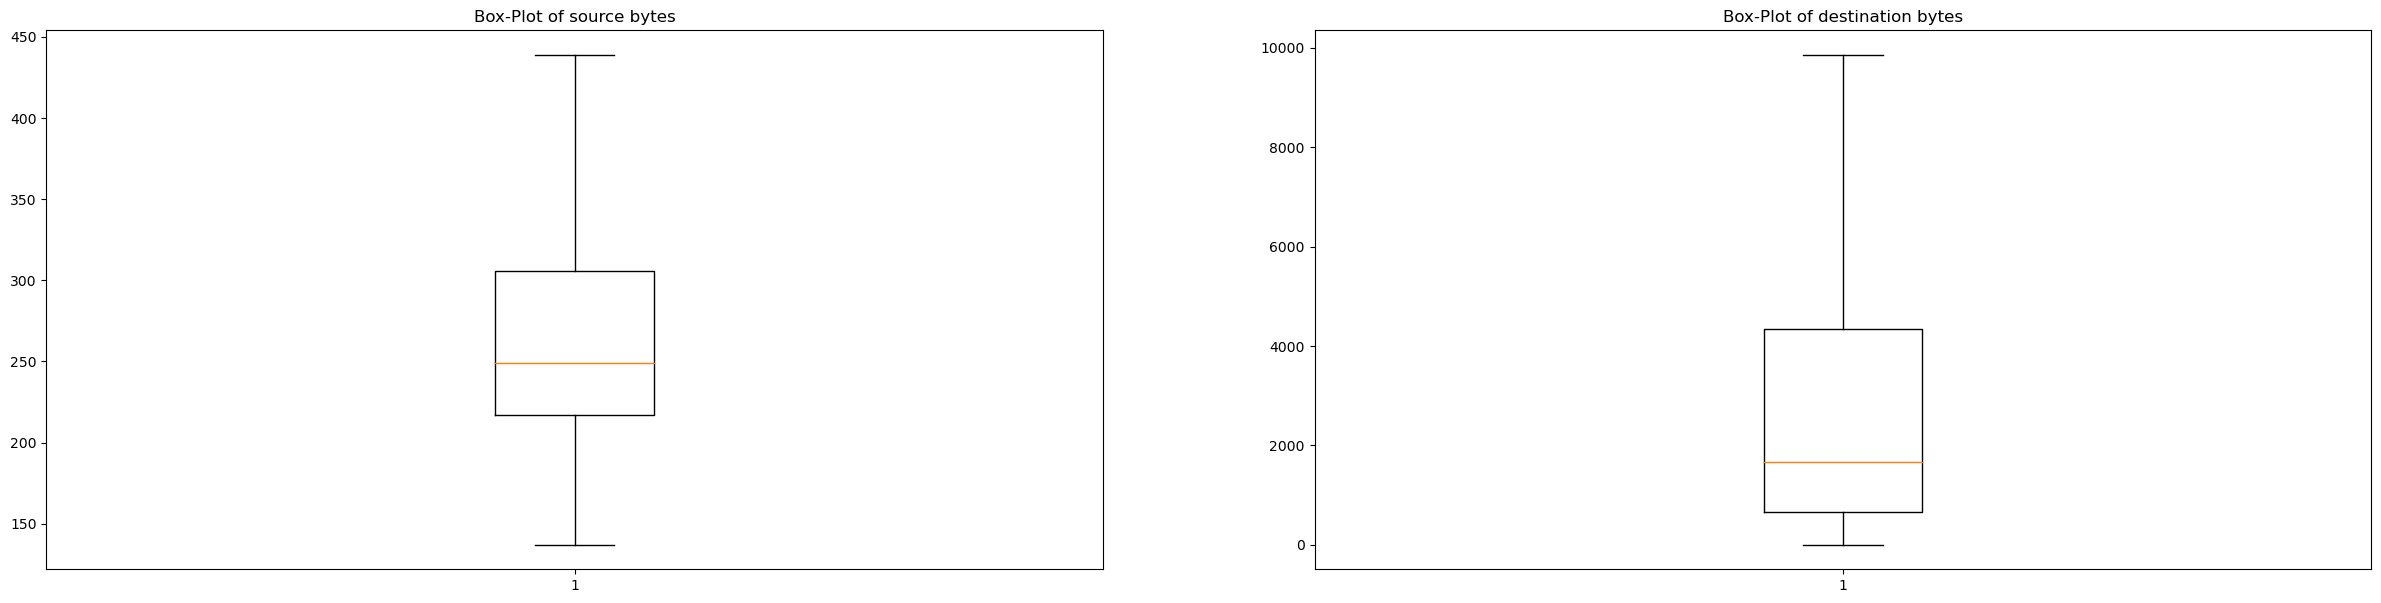

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,7))
ax1.set_title('Box-Plot of source bytes')
ax1.boxplot(dataset['Src_bytes'] ,showfliers = False)
ax2.set_title('Box-Plot of destination bytes')
ax2.boxplot(dataset['Dst_bytes'] ,showfliers = False)
plt.show()

As can be seen from the chart, the distribution of the data that describes the features is not symmetrical, meaning the distribution is positively skewed since for both charts the median is closer to the bottom of the box, and in addition, the whisker is shorter at the bottom edge of the box.

Since our data is positively skewed here, it has a higher number of data points with low values.

In [18]:
limit_lower_src , limit_upper_src = calculate_limits('Src_bytes')
lower_points_src = dataset[(dataset['Src_bytes'] < limit_lower_src)].shape[0]
upper_points_src = dataset[(dataset['Src_bytes'] > limit_upper_src)].shape[0]

print("Source bytes overview")
print(f'The number of points below the lower bound is {lower_points_src} The number of points above the upper bound is {upper_points_src}\n')

limit_lower_dst , limit_upper_dst = calculate_limits('Dst_bytes')
lower_points_dst = dataset[(dataset['Dst_bytes'] < limit_lower_dst)].shape[0]
upper_points_dst = dataset[(dataset['Dst_bytes'] > limit_upper_dst)].shape[0]

print("Destination bytes overview")
print(f'The number of points below the lower bound is {lower_points_dst} The number of points above the upper bound is {upper_points_dst}')



Source bytes overview
The number of points below the lower bound is 135 The number of points above the upper bound is 1874

Destination bytes overview
The number of points below the lower bound is 0 The number of points above the upper bound is 28847


# **Model**

---
To solve the binary classification problem, I used the **Isolation Random Forest** model.

In [19]:
from sklearn.ensemble import IsolationForest

In [20]:
# since sklearn models works with numpy array format we need to convert our dataset to numpy array
X = dataset.values

In [29]:
classifier = IsolationForest(contamination = .0041)
classifier.fit(X)
predictions = classifier.predict(X)

In [30]:
(predictions > 0).mean()

0.9958974558771964

In [31]:
anomalies = np.where(predictions < 0)

In [32]:
len(anomalies[0])

1053

In [18]:
# save the model for inference
import pickle
pickle.dump(classifier, open("classifier.pkl",'wb'))

# **Model Evaluation**

---

After we have trained the model on the given data set, we will now evaluate the model which is the process of using different evaluation metrics in order to evaluate the performance of the model.

> Since we have the data set : `conn_attack_anomaly_labels` which describes the labeling of the data set on which we trained the model, we can use the Confusion Matrix to see the ability of the model to classify the records correctly.


In [ ]:
labeled_dataset_path = "conn_attack_anomaly_labels.csv"
summary = pd.read_csv(labeled_dataset_path , names = ['record','label'] , header = None)

# insert the model predictions that correspond to the record id
summary.insert(1 , "prediction" , predictions)
# since the binary classification of sklearn isolation random forest return -1 to anomalies and 1 to normal we need to map the output. 
summary['prediction'] = summary['prediction'].map({1:0 , -1:1})
summary.head(5)

accuracy score : 0.9996064986169011
recall score : 0.9657534246575342

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    255648
           1       0.94      0.97      0.95      1022

    accuracy                           1.00    256670
   macro avg       0.97      0.98      0.98    256670
weighted avg       1.00      1.00      1.00    256670



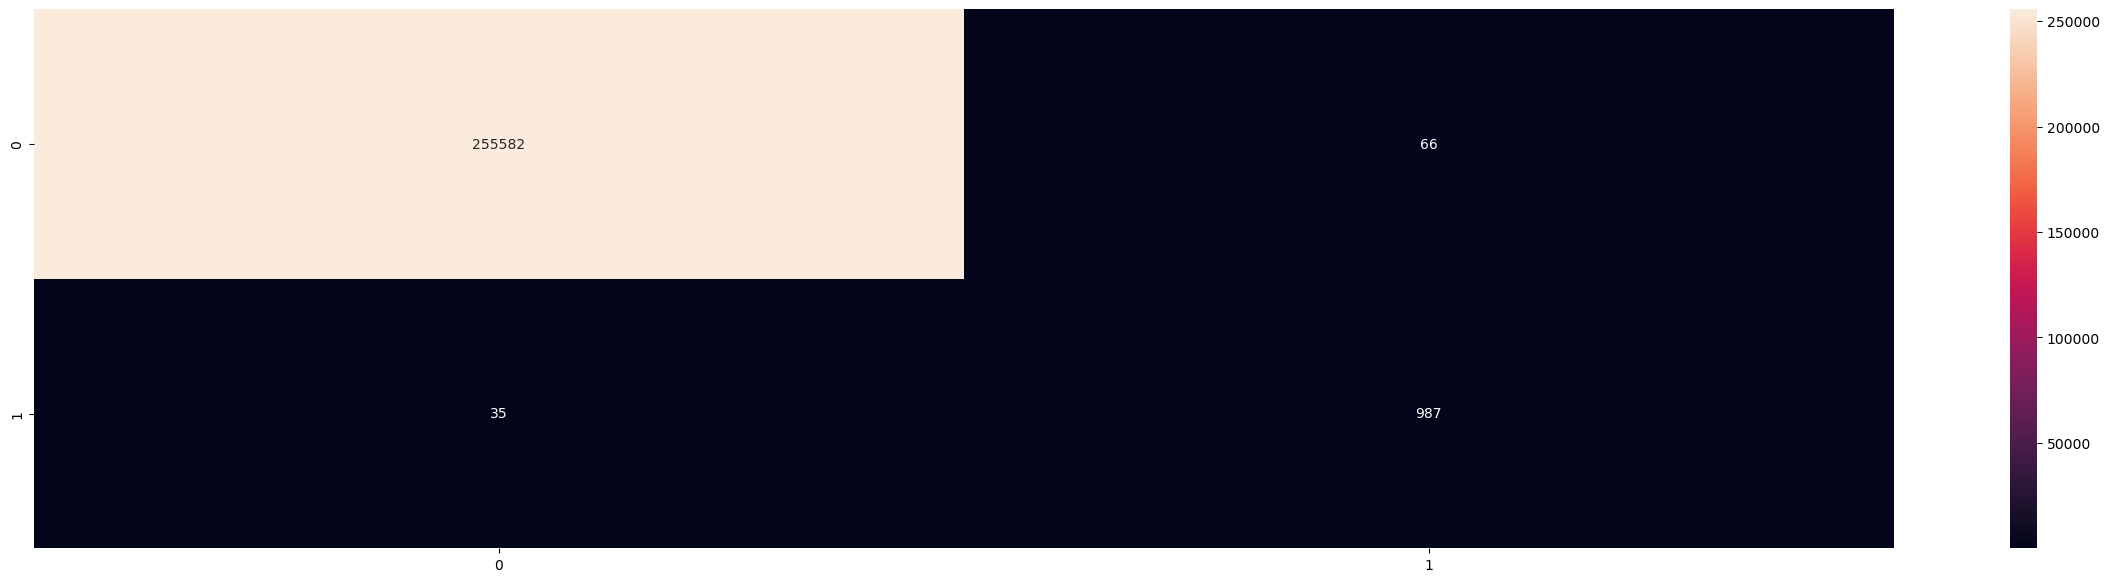

In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score , recall_score

cm = sns.heatmap(confusion_matrix(summary['label'], summary['prediction']), annot=True, fmt='d')
accuracy = accuracy_score(summary['label'], summary['prediction'])
recall = recall_score(summary['label'], summary['prediction'])
print(f'accuracy score : {accuracy}')
print(f'recall score : {recall}\n')

print(classification_report(summary['label'], summary['prediction']))

## PCA

---

Since the data set is very large and contains 4 features, we would like to reduce the dimensionality of the data set
and preserve as much information as possible.
For this purpose, we will use the Principal Component Analysis method which is a technique commonly used for reducing the dimensionality of data while preserving as much as possible of the information contained in the original data. 

PCA achieves this goal by projecting 
data onto a lower-dimensional subspace that retains most of the variance among the data points.

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


scalar = StandardScaler()
scalar.fit(dataset)
scaled_dataset = scalar.transform(dataset)

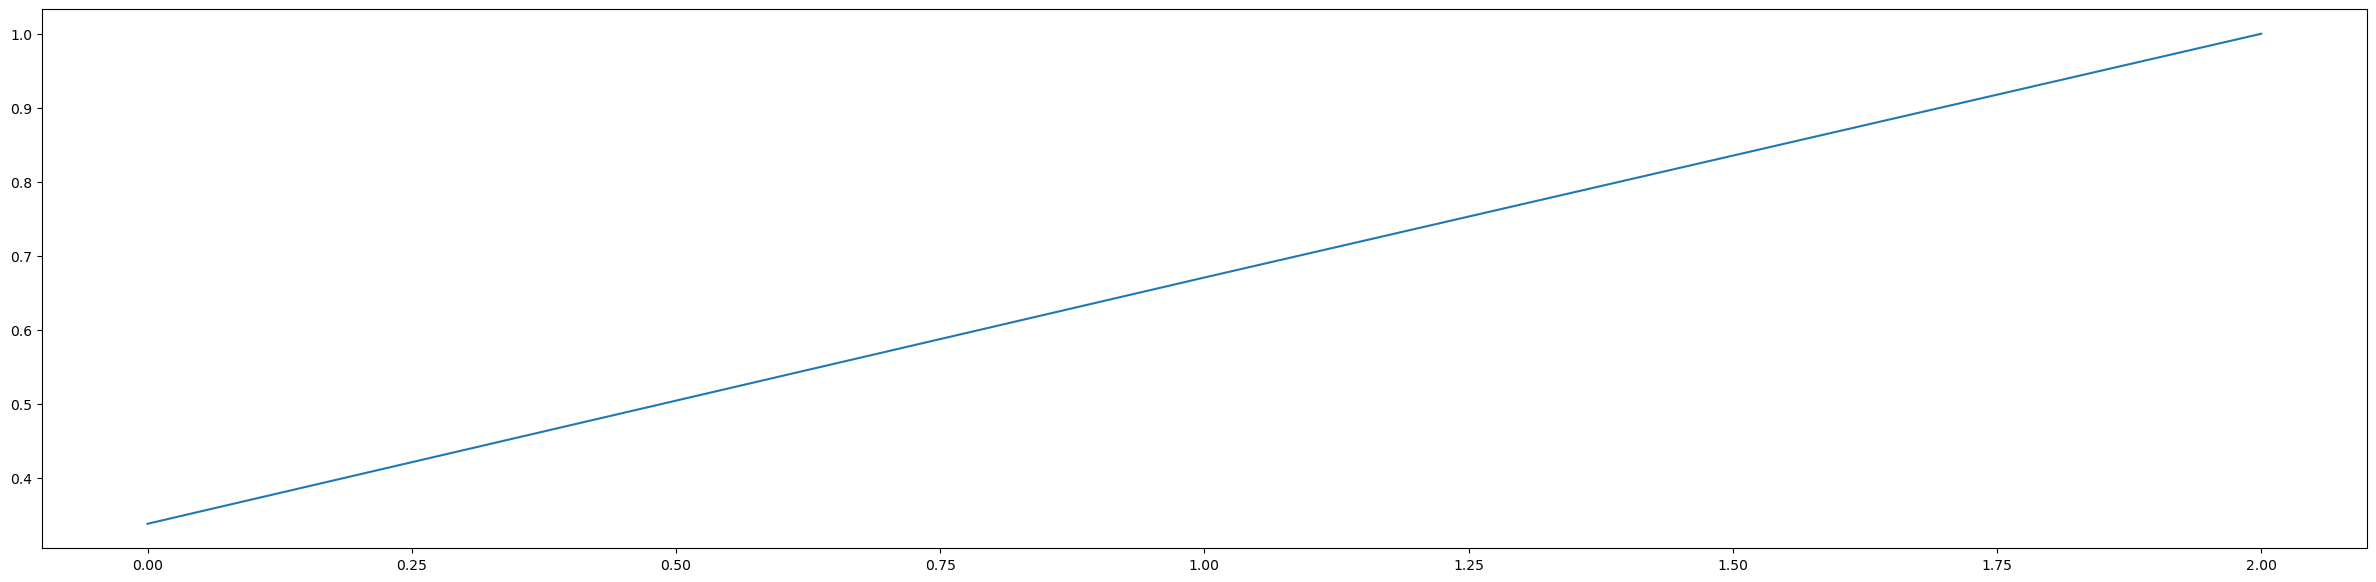

In [71]:
plt.rcParams["figure.figsize"] = (30,7)
pca_test = PCA(n_components = 3)
pca_test.fit(scaled_dataset)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.show()

As you can see, 2 components describe 99 percent of the variance in the dataset.
So we will reduce the dimension of the data set to 2 dimensions to demonstrate the points in 2D space.

In [67]:
pca = PCA(n_components = 2)
pca.fit(scaled_dataset)
x_pca = pca.transform(scaled_dataset)

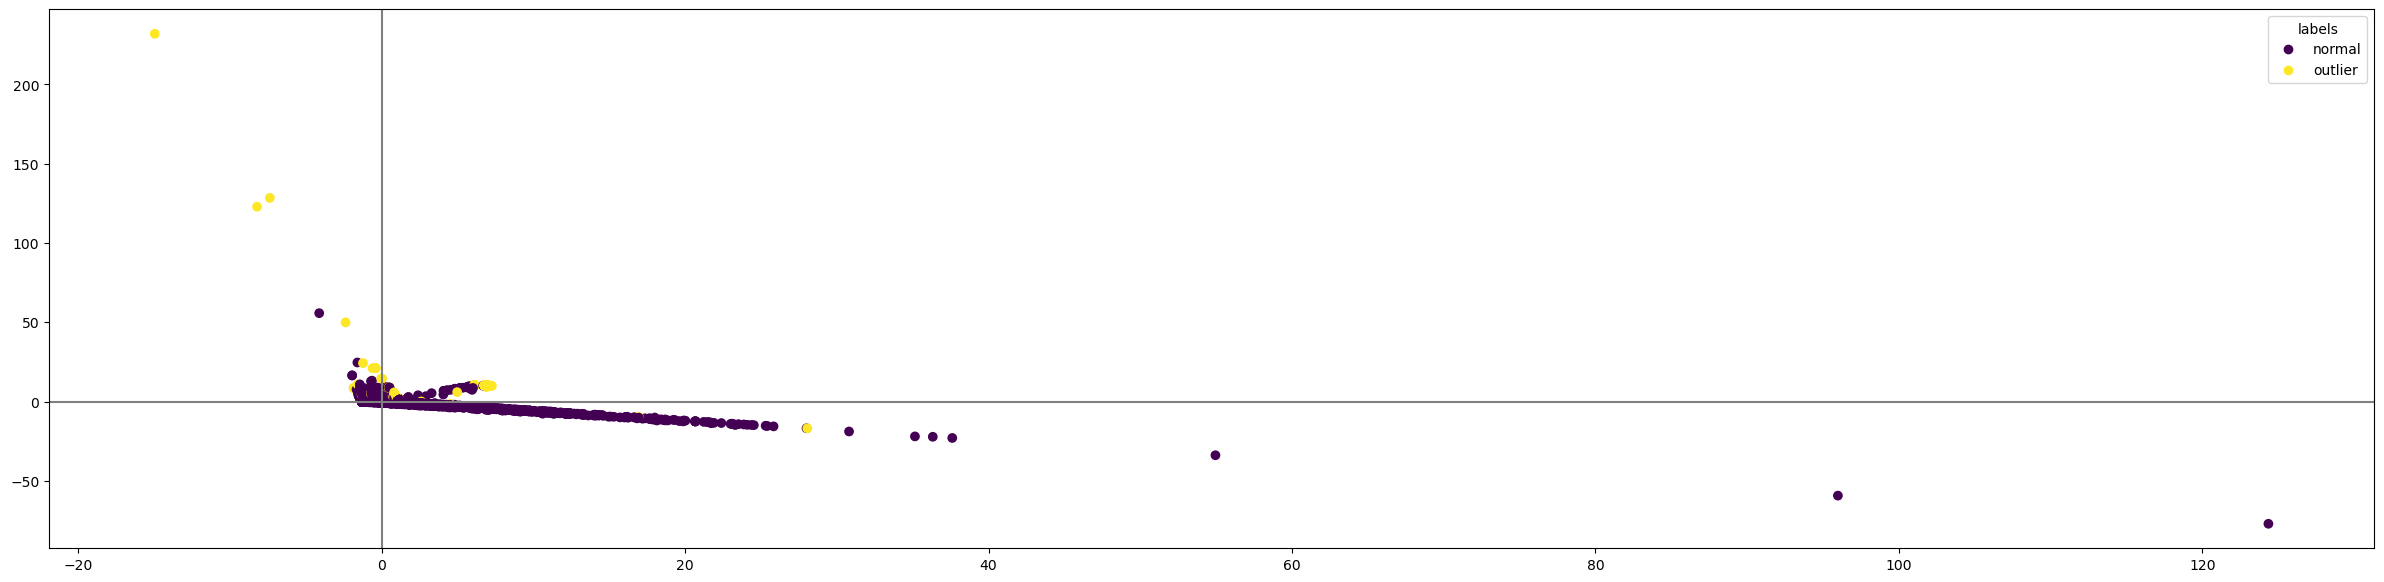

In [68]:
plt.figure(figsize=(30,7))
Y = np.array(summary['prediction'].to_list())

scatter = plt.scatter(x_pca[:,0], x_pca[:,1], c = Y)

# Creating Legends
labels = np.unique(Y)
handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]


plt.legend(handles, ['normal','outlier'], title = 'labels')
# end of defining legends

plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.show()


In [75]:
result = summary.drop(columns = "label" , axis = 1)
result.to_csv("results.csv")

Questions & Answers
---


**1. Data exploration - what have you learned?**
>   As part of the exploration of the data set, I first tried to examine how the data behaves not statistically way, I checked how the data looked and whether I can identify anomalous observations, for example, there are observations for which the number of source bytes is equal to zero and the number of destination bytes is greater than zero.

>   After that, I performed a statistical analysis by box charts through which it was possible to know that there is indeed an anomaly in the data of the various features. And I also learned from the chart that the distribution of the features is positively skewed. This means that the center of gravity is at relatively low values.

**2. Which algorithms group is suitable for this task and why?**

> Since our data set contains unlabeled observations, the set of algorithms suitable for this task is unsupervised machine learning algorithms.

**3. Please create a report that will explain how you solved the problem.**


 * **3.1 What is the approach you tried? Why them?**

> During the training, I performed trial and error on a large number of runs for the various parameters:
 
  * 1. n_estimators:
     > indicates the number of trees that will be built in the forest. During the runs, I noticed that the default number of 100 gives about the same results compared to a larger amount.
  * 2. contamination :
     > indicates in percentages the number of anomalous points from the data set. The default value is 0.1 percent of all data, and in each run, I increased the value by 0.001 percent, and I noticed that the accuracy is high when the value is 0.041 percent.

 * **3.2 How do you know the algorithm is good?**

> Given the labeled data set, at the end of each run, I compared the model results with the actual points results. I first saw that the model detects roughly the same quantities with values ranging between 0.035 and 0.041 percent defined as anomalous points, but what made me realize that the algorithm was good was by confusion matrix which is a table that is used to define the performance of the classification

**4. What is the accuracy and recall of the algorithm the team developed?**

> The accuracy score of the isolation random forest is 0.9996, And the recall score is 0.9657.The confusion matrix and the plot of the points in the two-dimensional space are shown above.


link to github repository : https://github.com/d0lev/AnomalyDetection